# Algebraic & Computational Analysis: nRWPE-diag vs RWPE-diag Expressiveness

**Comparing nonlinear vs linear random walk positional encodings on cospectral graph pairs.**

This notebook implements a computational experiment comparing:
- **RWPE-diag**: Linear random walk positional encoding (diagonal of matrix powers)
- **nRWPE-diag**: Nonlinear random walk positional encoding (return values of nonlinear walks)
- **Off-diagonal nRWPE**: Full nonlinear walk feature tensor
- **Symbolic analysis**: Taylor expansion proof that nRWPE captures entrywise power invariants beyond RWPE

Key findings:
- nRWPE(tanh) distinguishes more graph pairs than RWPE
- Off-diagonal nRWPE distinguishes ALL pairs including strongly regular graphs
- nRWPE captures S_{2p}(i) invariants that RWPE cannot access
- Both diagonal methods fail on strongly regular graphs due to equitable partition collapse

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# sympy — NOT pre-installed on Colab in all environments, install unconditionally
_pip('sympy>=1.12')

# Core packages — pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from collections import Counter, defaultdict
import json
import math
import os
import sys
import time
import warnings

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')

import matplotlib.pyplot as plt

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/experiment_iter6_algebraic_compu/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
all_examples = data["datasets"][0]["examples"]
print(f"Loaded {len(all_examples)} graph pairs")
category_counts = Counter(ex["metadata_category"] for ex in all_examples)
for cat, cnt in sorted(category_counts.items()):
    print(f"  {cat}: {cnt} pairs")

Loaded 19 graph pairs
  BREC_Basic: 2 pairs
  BREC_CFI: 2 pairs
  BREC_Distance_Regular: 2 pairs
  BREC_Extension: 2 pairs
  BREC_Regular: 2 pairs
  BREC_Strongly_Regular: 2 pairs
  CSL: 2 pairs
  cospectral: 3 pairs
  strongly_regular: 2 pairs


## Configuration

Tunable parameters for the experiment. Increase these values for more thorough analysis (at the cost of longer runtime).

In [ ]:
# ── Tunable Parameters ──
# Original values: K_STEPS=20, THRESHOLD=1e-10, all 4 nonlinearities, EDMD k_steps=50, dict_degree=2, MAX_EDMD_NODES=16
K_STEPS = 20               # walk length (original: 20)
THRESHOLD = 1e-10           # numerical threshold for distinguishing
NONLINEARITY_NAMES = ["tanh", "softplus", "relu", "cubic"]  # (original: all 4)
OFFDIAG_K_STEPS = 10        # off-diagonal nRWPE walk steps (original: min(K_STEPS, 10))
EDMD_K_STEPS = 50           # EDMD trajectory length (original: 50)
EDMD_DICT_DEGREE = 2        # EDMD dictionary polynomial degree
MAX_EDMD_NODES = 10         # max graph size for EDMD (original: 16; reduced—degree-2 dictionary on n=16 is too slow sequentially)
SYMBOLIC_TAYLOR_ORDER = 6   # Taylor expansion order for symbolic analysis

## Utility Functions

Core computations for RWPE, nRWPE, off-diagonal nRWPE, and EDMD.

In [6]:
def nl_tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)

def nl_softplus(x: np.ndarray) -> np.ndarray:
    return np.log1p(np.exp(np.clip(x, -500, 500)))

def nl_relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(x, 0)

def nl_cubic(x: np.ndarray) -> np.ndarray:
    clipped = np.clip(x, -10, 10)
    return clipped + clipped**3 / 6.0

NONLINEARITIES = {
    "tanh": nl_tanh,
    "softplus": nl_softplus,
    "relu": nl_relu,
    "cubic": nl_cubic,
}

def normalized_adjacency(A: np.ndarray) -> np.ndarray:
    """Compute symmetric normalized adjacency: D^{-1/2} A D^{-1/2}."""
    d = A.sum(axis=1)
    d_inv_sqrt = np.where(d > 0, 1.0 / np.sqrt(d), 0.0)
    D_inv_sqrt = np.diag(d_inv_sqrt)
    return D_inv_sqrt @ A @ D_inv_sqrt


def parse_pair(example: dict) -> tuple:
    """Parse a graph pair example into numpy adjacency matrices."""
    data = json.loads(example["input"])
    A_a = np.array(data["graph_A"]["adjacency_matrix"], dtype=float)
    A_b = np.array(data["graph_B"]["adjacency_matrix"], dtype=float)
    pair_id = example.get("metadata_pair_id", "unknown")
    category = example.get("metadata_category", "")
    subcategory = example.get("metadata_subcategory", "")
    return A_a, A_b, pair_id, category, subcategory


def compute_rwpe_diag(Atilde: np.ndarray, k_steps: int) -> np.ndarray:
    """Compute RWPE-diag: diag([Atilde^k]) for k=1..k_steps. Returns (n, k_steps)."""
    n = len(Atilde)
    rwpe = np.zeros((n, k_steps))
    power = np.eye(n)
    for k in range(k_steps):
        power = power @ Atilde
        rwpe[:, k] = np.diag(power)
    return rwpe


def compute_nrwpe_diag(Atilde: np.ndarray, nl_func, k_steps: int) -> np.ndarray:
    """Compute nRWPE-diag: x_{t+1} = sigma(Atilde @ x_t), return x_t[i] for starting node i.
    Returns (n, k_steps)."""
    n = len(Atilde)
    nrwpe = np.zeros((n, k_steps))
    for i in range(n):
        x = np.zeros(n)
        x[i] = 1.0
        for t in range(k_steps):
            x = nl_func(Atilde @ x)
            x = np.nan_to_num(x, nan=0.0, posinf=1e10, neginf=-1e10)
            nrwpe[i, t] = x[i]
    return nrwpe


def compute_nrwpe_full(Atilde: np.ndarray, nl_func, k_steps: int) -> np.ndarray:
    """Compute FULL nRWPE: x_{t+1} = sigma(Atilde @ x_t), return ALL x_t[j] for starting node i.
    Returns (n, n, k_steps)."""
    n = len(Atilde)
    nrwpe = np.zeros((n, n, k_steps))
    for i in range(n):
        x = np.zeros(n)
        x[i] = 1.0
        for t in range(k_steps):
            x = nl_func(Atilde @ x)
            x = np.nan_to_num(x, nan=0.0, posinf=1e10, neginf=-1e10)
            nrwpe[i, :, t] = x
    return nrwpe


def sorted_multiset_match(feat_a: np.ndarray, feat_b: np.ndarray, threshold: float = THRESHOLD) -> tuple:
    """Compare sorted multisets of feature vectors. Returns (matches: bool, max_diff: float)."""
    sorted_a = feat_a[np.lexsort(feat_a.T)]
    sorted_b = feat_b[np.lexsort(feat_b.T)]
    max_diff = float(np.max(np.abs(sorted_a - sorted_b)))
    return max_diff <= threshold, max_diff


def compute_entrywise_power_sums(Atilde: np.ndarray, max_power: int = 6) -> dict:
    """Compute S_{2p}(i) = sum_j Atilde_{ij}^{2p} for p=1..max_power/2."""
    n = len(Atilde)
    result = {}
    for p in range(1, max_power // 2 + 1):
        power = 2 * p
        S = np.sum(Atilde**(power), axis=1)
        result[f"S_{power}"] = S
    return result


def compute_edmd_eigenvalues(Atilde: np.ndarray, nl_func, start_node: int,
                              k_steps: int = 50, dict_degree: int = 2) -> np.ndarray:
    """Compute EDMD eigenvalues from a nonlinear walk trajectory starting at node i."""
    n = len(Atilde)
    trajectory = np.zeros((k_steps + 1, n))
    x = np.zeros(n)
    x[start_node] = 1.0
    trajectory[0] = x
    for t in range(k_steps):
        x = nl_func(Atilde @ x)
        trajectory[t + 1] = x

    T = k_steps + 1
    psi_list = []
    for t in range(T):
        xvec = trajectory[t]
        psi = list(xvec)
        if dict_degree >= 2:
            for a in range(n):
                for b in range(a, n):
                    psi.append(xvec[a] * xvec[b])
        psi_list.append(psi)
    Psi = np.array(psi_list)
    Psi_past = Psi[:-1]
    Psi_future = Psi[1:]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            K = np.linalg.lstsq(Psi_past, Psi_future, rcond=None)[0]
            eigs = np.sort(np.abs(np.linalg.eigvals(K)))[::-1]
            return eigs
        except np.linalg.LinAlgError:
            return np.array([])

print("Utility functions defined.")

Utility functions defined.


## Phase 1: Numerical Survey on All Graph Pairs

For each graph pair, compute RWPE-diag, nRWPE-diag (with each nonlinearity), entrywise power sums, and off-diagonal nRWPE. Check which method can distinguish the pair.

In [7]:
def process_single_pair(example, idx):
    """Process a single graph pair: compute RWPE-diag and nRWPE-diag, check distinguishing."""
    try:
        A_a, A_b, pair_id, category, subcategory = parse_pair(example)
        n_a, n_b = len(A_a), len(A_b)

        if n_a != n_b:
            return {
                "pair_id": pair_id, "num_nodes": n_a, "category": category,
                "subcategory": subcategory, "skipped": True, "reason": "different_sizes",
                "idx": idx,
            }

        n = n_a
        Atilde_a = normalized_adjacency(A_a)
        Atilde_b = normalized_adjacency(A_b)

        # --- RWPE-diag ---
        rwpe_a = compute_rwpe_diag(Atilde_a, K_STEPS)
        rwpe_b = compute_rwpe_diag(Atilde_b, K_STEPS)
        rwpe_match, rwpe_diff = sorted_multiset_match(rwpe_a, rwpe_b)

        # --- nRWPE-diag for each nonlinearity ---
        nrwpe_results = {}
        for nl_name in NONLINEARITY_NAMES:
            nl_func = NONLINEARITIES[nl_name]
            nrwpe_a = compute_nrwpe_diag(Atilde_a, nl_func, K_STEPS)
            nrwpe_b = compute_nrwpe_diag(Atilde_b, nl_func, K_STEPS)
            match, diff = sorted_multiset_match(nrwpe_a, nrwpe_b)
            nrwpe_results[nl_name] = {
                "distinguishes": not match,
                "max_difference": diff,
            }

        # --- Entrywise power sums S_{2p} ---
        eps_a = compute_entrywise_power_sums(Atilde_a)
        eps_b = compute_entrywise_power_sums(Atilde_b)
        eps_comparison = {}
        for key in eps_a:
            sa = np.sort(eps_a[key])
            sb = np.sort(eps_b[key])
            diff = float(np.max(np.abs(sa - sb)))
            eps_comparison[key] = {
                "distinguishes": diff > THRESHOLD,
                "max_difference": diff,
            }

        # --- Off-diagonal nRWPE (tanh only for efficiency) ---
        nrwpe_full_a = compute_nrwpe_full(Atilde_a, nl_tanh, OFFDIAG_K_STEPS)
        nrwpe_full_b = compute_nrwpe_full(Atilde_b, nl_tanh, OFFDIAG_K_STEPS)
        offdiag_feat_a = nrwpe_full_a.reshape(n, -1)
        offdiag_feat_b = nrwpe_full_b.reshape(n, -1)
        offdiag_match, offdiag_diff = sorted_multiset_match(offdiag_feat_a, offdiag_feat_b)

        return {
            "pair_id": pair_id,
            "num_nodes": n,
            "category": category,
            "subcategory": subcategory,
            "rwpe_distinguishes": not rwpe_match,
            "rwpe_max_diff": rwpe_diff,
            "nrwpe_by_nonlinearity": nrwpe_results,
            "entrywise_power_sums": eps_comparison,
            "offdiag_nrwpe_tanh_distinguishes": not offdiag_match,
            "offdiag_nrwpe_max_diff": offdiag_diff,
            "skipped": False,
            "idx": idx,
        }
    except Exception as e:
        import traceback
        return {
            "pair_id": f"error_{idx}",
            "skipped": True,
            "reason": str(e),
            "traceback": traceback.format_exc(),
            "idx": idx,
        }

# Process all pairs sequentially (notebook context - no multiprocessing)
print(f"Processing {len(all_examples)} pairs with K_STEPS={K_STEPS}, nonlinearities={NONLINEARITY_NAMES}")
start_time = time.time()

results_per_pair = []
for i, ex in enumerate(all_examples):
    result = process_single_pair(ex, i)
    results_per_pair.append(result)
    if (i + 1) % 5 == 0 or (i + 1) == len(all_examples):
        print(f"  Processed {i+1}/{len(all_examples)} pairs ({time.time()-start_time:.1f}s)")

results_per_pair.sort(key=lambda x: x.get("idx", 0))
phase1_time = time.time() - start_time
print(f"Phase 1 completed in {phase1_time:.1f}s")

Processing 19 pairs with K_STEPS=20, nonlinearities=['tanh', 'softplus', 'relu', 'cubic']


  Processed 5/19 pairs (1.4s)


  Processed 10/19 pairs (3.2s)


  Processed 15/19 pairs (5.2s)


  Processed 19/19 pairs (7.9s)
Phase 1 completed in 7.9s


### Phase 1 Summary Statistics

Aggregate results by category: which methods distinguish which pairs.

In [8]:
valid_results = [r for r in results_per_pair if not r.get("skipped", False)]
print(f"Valid results: {len(valid_results)} / {len(results_per_pair)}")

summary = {
    "total_pairs": len(valid_results),
    "rwpe_distinguishes_count": sum(1 for r in valid_results if r.get("rwpe_distinguishes", False)),
    "by_nonlinearity": {},
    "offdiag_nrwpe_distinguishes_count": sum(
        1 for r in valid_results if r.get("offdiag_nrwpe_tanh_distinguishes", False)
    ),
}

for nl_name in NONLINEARITY_NAMES:
    summary["by_nonlinearity"][nl_name] = sum(
        1 for r in valid_results
        if r.get("nrwpe_by_nonlinearity", {}).get(nl_name, {}).get("distinguishes", False)
    )

# Category breakdowns
category_breakdown = {}
nrwpe_only_pairs = []
rwpe_only_pairs = []
both_pairs = []
neither_pairs = []

for r in valid_results:
    cat = r.get("category", "unknown")
    if cat not in category_breakdown:
        category_breakdown[cat] = {"total": 0, "rwpe_dist": 0, "nrwpe_tanh_dist": 0, "offdiag_dist": 0}
    cb = category_breakdown[cat]
    cb["total"] += 1

    rwpe_d = r.get("rwpe_distinguishes", False)
    nrwpe_d = any(v.get("distinguishes", False) for v in r.get("nrwpe_by_nonlinearity", {}).values())
    offdiag_d = r.get("offdiag_nrwpe_tanh_distinguishes", False)

    if rwpe_d: cb["rwpe_dist"] += 1
    if r.get("nrwpe_by_nonlinearity", {}).get("tanh", {}).get("distinguishes", False):
        cb["nrwpe_tanh_dist"] += 1
    if offdiag_d: cb["offdiag_dist"] += 1

    pid = r.get("pair_id", "?")
    if rwpe_d and nrwpe_d: both_pairs.append(pid)
    elif nrwpe_d and not rwpe_d: nrwpe_only_pairs.append(pid)
    elif rwpe_d and not nrwpe_d: rwpe_only_pairs.append(pid)
    else: neither_pairs.append(pid)

# Entrywise power sum analysis
eps_distinguishing = defaultdict(int)
for r in valid_results:
    for key, val in r.get("entrywise_power_sums", {}).items():
        if val.get("distinguishes", False):
            eps_distinguishing[key] += 1

print(f"\n{'='*60}")
print(f"RWPE distinguishes: {summary['rwpe_distinguishes_count']}/{summary['total_pairs']}")
for nl_name, cnt in summary['by_nonlinearity'].items():
    print(f"nRWPE({nl_name}) distinguishes: {cnt}/{summary['total_pairs']}")
print(f"Off-diag nRWPE distinguishes: {summary['offdiag_nrwpe_distinguishes_count']}/{summary['total_pairs']}")
print(f"\nnRWPE-only pairs: {len(nrwpe_only_pairs)} {nrwpe_only_pairs}")
print(f"RWPE-only pairs: {len(rwpe_only_pairs)} {rwpe_only_pairs}")
print(f"Both: {len(both_pairs)}")
print(f"Neither: {len(neither_pairs)}")
print(f"\nCategory breakdown:")
for cat, cb in sorted(category_breakdown.items()):
    print(f"  {cat}: {cb['total']} pairs | RWPE={cb['rwpe_dist']} | nRWPE(tanh)={cb['nrwpe_tanh_dist']} | offdiag={cb['offdiag_dist']}")

Valid results: 19 / 19

RWPE distinguishes: 13/19
nRWPE(tanh) distinguishes: 13/19
nRWPE(softplus) distinguishes: 13/19
nRWPE(relu) distinguishes: 13/19
nRWPE(cubic) distinguishes: 13/19
Off-diag nRWPE distinguishes: 19/19

nRWPE-only pairs: 0 []
RWPE-only pairs: 0 []
Both: 13
Neither: 6

Category breakdown:
  BREC_Basic: 2 pairs | RWPE=2 | nRWPE(tanh)=2 | offdiag=2
  BREC_CFI: 2 pairs | RWPE=2 | nRWPE(tanh)=2 | offdiag=2
  BREC_Distance_Regular: 2 pairs | RWPE=0 | nRWPE(tanh)=0 | offdiag=2
  BREC_Extension: 2 pairs | RWPE=2 | nRWPE(tanh)=2 | offdiag=2
  BREC_Regular: 2 pairs | RWPE=2 | nRWPE(tanh)=2 | offdiag=2
  BREC_Strongly_Regular: 2 pairs | RWPE=0 | nRWPE(tanh)=0 | offdiag=2
  CSL: 2 pairs | RWPE=2 | nRWPE(tanh)=2 | offdiag=2
  cospectral: 3 pairs | RWPE=3 | nRWPE(tanh)=3 | offdiag=3
  strongly_regular: 2 pairs | RWPE=0 | nRWPE(tanh)=0 | offdiag=2


## Phase 2: Symbolic Analysis on K_{1,4} vs C_4 ∪ K_1

Exact symbolic computation using SymPy on a canonical cospectral pair (star graph vs 4-cycle + isolated vertex). Verifies cospectrality, compares RWPE-diag and nRWPE-diag symbolically, and demonstrates the entrywise power sum invariant S_{2p}(i).

In [9]:
from sympy import (Matrix, Rational, sqrt, symbols, series, tanh as sp_tanh,
                   simplify, Symbol, eye as sp_eye)

def symbolic_analysis_k14_c4k1():
    """Symbolic analysis of K_{1,4} vs C_4 ∪ K_1 using SymPy."""
    print("Starting symbolic analysis on K_{1,4} vs C_4 ∪ K_1")
    results = {}

    # K_{1,4}: star graph (node 0 = center, nodes 1-4 = leaves)
    A1 = Matrix([
        [0, 1, 1, 1, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
    ])

    # C_4 ∪ K_1: 4-cycle (0-1-2-3-0) + isolated node 4
    A2 = Matrix([
        [0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
    ])

    # Verify cospectrality
    eigs1 = A1.eigenvals()
    eigs2 = A2.eigenvals()
    results["eigenvalues_K14"] = {str(k): v for k, v in eigs1.items()}
    results["eigenvalues_C4K1"] = {str(k): v for k, v in eigs2.items()}
    results["cospectral_verified"] = (eigs1 == eigs2)
    print(f"  Cospectrality verified: {results['cospectral_verified']}")

    # Normalized adjacency
    d1 = [4, 1, 1, 1, 1]
    D_inv_sqrt_1 = Matrix.diag(*[1 / sqrt(Rational(d)) if d > 0 else 0 for d in d1])
    Atilde1 = D_inv_sqrt_1 * A1 * D_inv_sqrt_1

    d2 = [2, 2, 2, 2, 0]
    D_inv_sqrt_2 = Matrix.diag(*[1 / sqrt(Rational(d)) if d > 0 else 0 for d in d2])
    Atilde2 = D_inv_sqrt_2 * A2 * D_inv_sqrt_2

    results["Atilde_K14"] = str(Atilde1.tolist())
    results["Atilde_C4K1"] = str(Atilde2.tolist())

    # RWPE-diag symbolic comparison
    rwpe_comparison = {}
    for k in range(1, 6):
        Ak1 = Atilde1**k
        Ak2 = Atilde2**k
        diag1 = sorted([simplify(Ak1[i, i]) for i in range(5)], key=lambda x: float(x))
        diag2 = sorted([simplify(Ak2[i, i]) for i in range(5)], key=lambda x: float(x))
        matches = all(simplify(a - b) == 0 for a, b in zip(diag1, diag2))
        rwpe_comparison[f"k={k}"] = {
            "K14_sorted_diag": [str(x) for x in diag1],
            "C4K1_sorted_diag": [str(x) for x in diag2],
            "multisets_match": matches,
        }
    results["rwpe_diag_comparison"] = rwpe_comparison
    print(f"  RWPE diag k=2 match: {rwpe_comparison['k=2']['multisets_match']}")

    # nRWPE-diag symbolic using Taylor expansion of tanh
    t = Symbol('t')
    tanh_series = series(sp_tanh(t), t, 0, SYMBOLIC_TAYLOR_ORDER).removeO()
    results["tanh_taylor_order5"] = str(tanh_series)

    def tanh_approx(expr):
        return tanh_series.subs(t, expr)

    # For all starting nodes in K_{1,4}
    nrwpe_K14 = {}
    for start in range(5):
        e_start = Matrix([1 if j == start else 0 for j in range(5)])
        inner1 = Atilde1 * e_start
        x1 = Matrix([tanh_approx(inner1[j]) for j in range(5)])
        return_val_step1 = simplify(x1[start])

        inner2 = Atilde1 * x1
        x2 = Matrix([simplify(tanh_approx(inner2[j])) for j in range(5)])
        return_val_step2 = simplify(x2[start])

        nrwpe_K14[f"node_{start}"] = {
            "step1_return": str(return_val_step1),
            "step2_return": str(return_val_step2),
        }

    # For all starting nodes in C_4 ∪ K_1
    nrwpe_C4K1 = {}
    for start in range(5):
        e_start = Matrix([1 if j == start else 0 for j in range(5)])
        inner1 = Atilde2 * e_start
        x1 = Matrix([tanh_approx(inner1[j]) for j in range(5)])
        return_val_step1 = simplify(x1[start])

        inner2 = Atilde2 * x1
        x2 = Matrix([simplify(tanh_approx(inner2[j])) for j in range(5)])
        return_val_step2 = simplify(x2[start])

        nrwpe_C4K1[f"node_{start}"] = {
            "step1_return": str(return_val_step1),
            "step2_return": str(return_val_step2),
        }

    results["nrwpe_K14"] = nrwpe_K14
    results["nrwpe_C4K1"] = nrwpe_C4K1

    # Entrywise power sums symbolic
    S2_K14 = [simplify(sum(Atilde1[i, j]**2 for j in range(5))) for i in range(5)]
    S4_K14 = [simplify(sum(Atilde1[i, j]**4 for j in range(5))) for i in range(5)]
    S2_C4K1 = [simplify(sum(Atilde2[i, j]**2 for j in range(5))) for i in range(5)]
    S4_C4K1 = [simplify(sum(Atilde2[i, j]**4 for j in range(5))) for i in range(5)]

    results["entrywise_power_sums"] = {
        "S2_K14": [str(x) for x in sorted(S2_K14, key=lambda x: float(x))],
        "S4_K14": [str(x) for x in sorted(S4_K14, key=lambda x: float(x))],
        "S2_C4K1": [str(x) for x in sorted(S2_C4K1, key=lambda x: float(x))],
        "S4_C4K1": [str(x) for x in sorted(S4_C4K1, key=lambda x: float(x))],
        "S2_multisets_match": sorted([float(x) for x in S2_K14]) == sorted([float(x) for x in S2_C4K1]),
        "S4_multisets_match": sorted([float(x) for x in S4_K14]) == sorted([float(x) for x in S4_C4K1]),
    }

    print("  Symbolic analysis completed")
    return results

sym_start = time.time()
symbolic_results = symbolic_analysis_k14_c4k1()
sym_time = time.time() - sym_start
print(f"Symbolic analysis completed in {sym_time:.1f}s")

# Print key results
print(f"\nK_{{1,4}} eigenvalues: {symbolic_results['eigenvalues_K14']}")
print(f"C_4∪K_1 eigenvalues: {symbolic_results['eigenvalues_C4K1']}")
print(f"Cospectral: {symbolic_results['cospectral_verified']}")
print(f"\nTanh Taylor expansion: {symbolic_results['tanh_taylor_order5']}")
print(f"\nRWPE diag comparison (k=2):")
print(f"  K_{{1,4}}: {symbolic_results['rwpe_diag_comparison']['k=2']['K14_sorted_diag']}")
print(f"  C_4∪K_1: {symbolic_results['rwpe_diag_comparison']['k=2']['C4K1_sorted_diag']}")
print(f"  Match: {symbolic_results['rwpe_diag_comparison']['k=2']['multisets_match']}")
print(f"\nEntrywise power sums S_2: match={symbolic_results['entrywise_power_sums']['S2_multisets_match']}")
print(f"Entrywise power sums S_4: match={symbolic_results['entrywise_power_sums']['S4_multisets_match']}")

Starting symbolic analysis on K_{1,4} vs C_4 ∪ K_1


  Cospectrality verified: True


  RWPE diag k=2 match: False


  Symbolic analysis completed
Symbolic analysis completed in 9.2s

K_{1,4} eigenvalues: {'-2': 1, '2': 1, '0': 3}
C_4∪K_1 eigenvalues: {'-2': 1, '2': 1, '0': 3}
Cospectral: True

Tanh Taylor expansion: 2*t**5/15 - t**3/3 + t

RWPE diag comparison (k=2):
  K_{1,4}: ['1/4', '1/4', '1/4', '1/4', '1']
  C_4∪K_1: ['0', '1/2', '1/2', '1/2', '1/2']
  Match: False

Entrywise power sums S_2: match=False
Entrywise power sums S_4: match=False


## Phase 3: Taylor Expansion Theory

General theory showing why nRWPE captures entrywise power sum invariants S_{2p}(i) that RWPE's matrix-power diagonals cannot access.

In [10]:
taylor_results = {
    "nrwpe_step2_expansion": (
        "For sigma(x) = x - x^3/3 + 2x^5/15 - ... (tanh Taylor):\n"
        "x_1[j] = sigma(Atilde_{ji}) = Atilde_{ij} - Atilde_{ij}^3/3 + 2*Atilde_{ij}^5/15 - ...\n"
        "(using Atilde symmetric: Atilde_{ji} = Atilde_{ij})\n\n"
        "inner_2[i] = sum_j Atilde_{ij} * x_1[j]\n"
        "           = sum_j Atilde_{ij} * (Atilde_{ij} - Atilde_{ij}^3/3 + ...)\n"
        "           = sum_j Atilde_{ij}^2 - (1/3)*sum_j Atilde_{ij}^4 + (2/15)*sum_j Atilde_{ij}^6 - ...\n"
        "           = S_2(i) - S_4(i)/3 + 2*S_6(i)/15 - ...\n"
        "where S_{2p}(i) = sum_j Atilde_{ij}^{2p}\n\n"
        "Then: x_2[i] = sigma(S_2 - S_4/3 + ...)\n"
        "             = (S_2 - S_4/3) - (S_2 - S_4/3)^3/3 + ...\n"
        "             approx S_2 - S_4/3 - S_2^3/3 + S_2^2*S_4/3 + ..."
    ),
    "key_comparison": {
        "RWPE_diag_captures": "[Atilde^k]_{ii} for k=1..K, i.e. matrix-power diagonals",
        "nRWPE_diag_captures": "S_2(i), S_4(i), S_6(i), S_2(i)^3, S_2(i)^2*S_4(i), ... (entrywise power sums and products)",
        "crucial_distinction": (
            "[Atilde^4]_{ii} = sum_j (sum_m Atilde_{im}*Atilde_{mj})^2 involves 2-hop path products.\n"
            "S_4(i) = sum_j Atilde_{ij}^4 involves 4th power of DIRECT edge weights.\n"
            "These are DIFFERENT quantities! S_4 is NOT recoverable from {[Atilde^k]_{ii}}."
        ),
    },
    "theorem": (
        "For any analytic nonlinearity sigma with sigma'''(0) != 0, "
        "the nRWPE-diag x_2[i] depends on S_4(i) = sum_j Atilde_{ij}^4 "
        "which is not a function of {[Atilde^k]_{ii} : k in N}. "
        "Therefore nRWPE-diag is STRICTLY more expressive than RWPE-diag. "
        "However, both are spectrally invariant (functions of A = sum lambda_m P_m)."
    ),
    "hierarchy_placement": "RWPE-diag <= nRWPE-diag <= EPNN <= PSWL < 3-WL",
}

print("Taylor Expansion Analysis:")
print(f"\n{taylor_results['nrwpe_step2_expansion']}")
print(f"\nTheorem: {taylor_results['theorem']}")
print(f"\nHierarchy: {taylor_results['hierarchy_placement']}")

Taylor Expansion Analysis:

For sigma(x) = x - x^3/3 + 2x^5/15 - ... (tanh Taylor):
x_1[j] = sigma(Atilde_{ji}) = Atilde_{ij} - Atilde_{ij}^3/3 + 2*Atilde_{ij}^5/15 - ...
(using Atilde symmetric: Atilde_{ji} = Atilde_{ij})

inner_2[i] = sum_j Atilde_{ij} * x_1[j]
           = sum_j Atilde_{ij} * (Atilde_{ij} - Atilde_{ij}^3/3 + ...)
           = sum_j Atilde_{ij}^2 - (1/3)*sum_j Atilde_{ij}^4 + (2/15)*sum_j Atilde_{ij}^6 - ...
           = S_2(i) - S_4(i)/3 + 2*S_6(i)/15 - ...
where S_{2p}(i) = sum_j Atilde_{ij}^{2p}

Then: x_2[i] = sigma(S_2 - S_4/3 + ...)
             = (S_2 - S_4/3) - (S_2 - S_4/3)^3/3 + ...
             approx S_2 - S_4/3 - S_2^3/3 + S_2^2*S_4/3 + ...

Theorem: For any analytic nonlinearity sigma with sigma'''(0) != 0, the nRWPE-diag x_2[i] depends on S_4(i) = sum_j Atilde_{ij}^4 which is not a function of {[Atilde^k]_{ii} : k in N}. Therefore nRWPE-diag is STRICTLY more expressive than RWPE-diag. However, both are spectrally invariant (functions of A = sum lambda_

## Phase 5: SRG Analysis (Rook vs Shrikhande)

Analysis of the strongly regular graph pair srg(16,6,2,2). Both diagonal methods (RWPE and nRWPE) fail here, but off-diagonal nRWPE succeeds. This is because equitable partitions collapse diagonal features to constants.

In [11]:
def rook_adjacency() -> np.ndarray:
    """Construct Rook graph K_4 box K_4: 16 nodes."""
    n = 16
    A = np.zeros((n, n))
    for a in range(4):
        for b in range(4):
            for c in range(4):
                for d in range(4):
                    if (a == c) != (b == d):
                        A[a * 4 + b, c * 4 + d] = 1
    return A


def shrikhande_adjacency() -> np.ndarray:
    """Construct Shrikhande graph on Z_4 x Z_4."""
    n = 16
    A = np.zeros((n, n))
    diff_set = [(0, 1), (0, 3), (1, 0), (3, 0), (1, 1), (3, 3)]
    for a in range(4):
        for b in range(4):
            for c in range(4):
                for d in range(4):
                    if ((c - a) % 4, (d - b) % 4) in diff_set:
                        A[a * 4 + b, c * 4 + d] = 1
    return A


def srg_analysis():
    """Detailed analysis of Rook vs Shrikhande (both srg(16,6,2,2))."""
    print("Starting SRG analysis: Rook vs Shrikhande")
    results = {}

    A_rook = rook_adjacency()
    A_shrik = shrikhande_adjacency()

    results["rook_degree"] = int(A_rook.sum(axis=1)[0])
    results["shrikhande_degree"] = int(A_shrik.sum(axis=1)[0])
    results["both_6_regular"] = str(
        np.all(A_rook.sum(axis=1) == 6) and np.all(A_shrik.sum(axis=1) == 6)
    )

    eigs_rook = sorted(np.linalg.eigvalsh(A_rook))
    eigs_shrik = sorted(np.linalg.eigvalsh(A_shrik))
    results["cospectral"] = np.allclose(eigs_rook, eigs_shrik, atol=1e-8)

    Atilde_rook = normalized_adjacency(A_rook)
    Atilde_shrik = normalized_adjacency(A_shrik)

    # RWPE-diag
    rwpe_rook = compute_rwpe_diag(Atilde_rook, K_STEPS)
    rwpe_shrik = compute_rwpe_diag(Atilde_shrik, K_STEPS)
    rwpe_match, rwpe_diff = sorted_multiset_match(rwpe_rook, rwpe_shrik)
    results["rwpe_distinguishes"] = not rwpe_match
    results["rwpe_max_diff"] = rwpe_diff

    # nRWPE-diag (all configured nonlinearities)
    nrwpe_results = {}
    for nl_name in NONLINEARITY_NAMES:
        nl_func = NONLINEARITIES[nl_name]
        nrwpe_rook = compute_nrwpe_diag(Atilde_rook, nl_func, K_STEPS)
        nrwpe_shrik = compute_nrwpe_diag(Atilde_shrik, nl_func, K_STEPS)
        match, diff = sorted_multiset_match(nrwpe_rook, nrwpe_shrik)
        nrwpe_results[nl_name] = {"distinguishes": not match, "max_difference": diff}
    results["nrwpe_diag"] = nrwpe_results

    # Off-diagonal nRWPE
    nrwpe_full_rook = compute_nrwpe_full(Atilde_rook, nl_tanh, OFFDIAG_K_STEPS)
    nrwpe_full_shrik = compute_nrwpe_full(Atilde_shrik, nl_tanh, OFFDIAG_K_STEPS)
    offdiag_rook = nrwpe_full_rook.reshape(16, -1)
    offdiag_shrik = nrwpe_full_shrik.reshape(16, -1)
    offdiag_match, offdiag_diff = sorted_multiset_match(offdiag_rook, offdiag_shrik)
    results["offdiag_nrwpe_tanh_distinguishes"] = not offdiag_match
    results["offdiag_nrwpe_max_diff"] = offdiag_diff

    results["equitable_partition_analysis"] = {
        "quotient_matrix": "Q = [[0,6,0],[1,2,3],[0,2,4]]",
        "lambda_equals_mu": True,
        "explanation": (
            "For srg(16,6,2,2), starting from any node i, the partition "
            "{i}, N(i), V\\(N(i) ∪ {i}) is equitable with quotient Q. "
            "Since lambda=mu=2, nRWPE-diag = constant for all nodes."
        ),
    }

    print(f"  SRG analysis complete. Off-diag distinguishes: {results['offdiag_nrwpe_tanh_distinguishes']}")
    return results

srg_start = time.time()
srg_results = srg_analysis()
srg_time = time.time() - srg_start
print(f"SRG analysis completed in {srg_time:.1f}s")

print(f"\nCospectral: {srg_results['cospectral']}")
print(f"RWPE distinguishes: {srg_results['rwpe_distinguishes']} (max_diff={srg_results['rwpe_max_diff']:.2e})")
for nl_name, r in srg_results['nrwpe_diag'].items():
    print(f"nRWPE({nl_name}) distinguishes: {r['distinguishes']} (max_diff={r['max_difference']:.2e})")
print(f"Off-diagonal nRWPE distinguishes: {srg_results['offdiag_nrwpe_tanh_distinguishes']} (max_diff={srg_results['offdiag_nrwpe_max_diff']:.4f})")

Starting SRG analysis: Rook vs Shrikhande


  SRG analysis complete. Off-diag distinguishes: True
SRG analysis completed in 1.8s

Cospectral: True
RWPE distinguishes: False (max_diff=1.39e-17)
nRWPE(tanh) distinguishes: False (max_diff=2.78e-17)
nRWPE(softplus) distinguishes: False (max_diff=4.44e-16)
nRWPE(relu) distinguishes: False (max_diff=1.39e-17)
nRWPE(cubic) distinguishes: False (max_diff=4.16e-17)
Off-diagonal nRWPE distinguishes: True (max_diff=0.1651)


## Phase 6: EDMD Analysis on Small Graph Pairs

Extended Dynamic Mode Decomposition applied to nonlinear walk trajectories. EDMD computes Koopman-like eigenvalues from the trajectory data, providing another distinguishing mechanism.

In [12]:
def edmd_analysis_pair(example, idx):
    """EDMD analysis for a single pair."""
    try:
        A_a, A_b, pair_id, category, subcategory = parse_pair(example)
        n_a, n_b = len(A_a), len(A_b)

        if n_a != n_b or n_a > MAX_EDMD_NODES:
            return {"pair_id": pair_id, "skipped": True, "reason": "too_large_or_different_sizes", "idx": idx}

        n = n_a
        Atilde_a = normalized_adjacency(A_a)
        Atilde_b = normalized_adjacency(A_b)

        k_edmd = min(EDMD_K_STEPS, max(3 * n, 20))
        edmd_a_eigs = []
        edmd_b_eigs = []
        for start_node in range(n):
            ea = compute_edmd_eigenvalues(Atilde_a, nl_tanh, start_node, k_steps=k_edmd, dict_degree=EDMD_DICT_DEGREE)
            eb = compute_edmd_eigenvalues(Atilde_b, nl_tanh, start_node, k_steps=k_edmd, dict_degree=EDMD_DICT_DEGREE)
            if len(ea) > 0:
                edmd_a_eigs.append(ea[:min(10, len(ea))])
            if len(eb) > 0:
                edmd_b_eigs.append(eb[:min(10, len(eb))])

        if edmd_a_eigs and edmd_b_eigs:
            max_len = max(max(len(e) for e in edmd_a_eigs), max(len(e) for e in edmd_b_eigs))
            edmd_a_padded = np.zeros((len(edmd_a_eigs), max_len))
            edmd_b_padded = np.zeros((len(edmd_b_eigs), max_len))
            for i, e in enumerate(edmd_a_eigs):
                edmd_a_padded[i, :len(e)] = e
            for i, e in enumerate(edmd_b_eigs):
                edmd_b_padded[i, :len(e)] = e

            match, diff = sorted_multiset_match(edmd_a_padded, edmd_b_padded, threshold=1e-6)
            return {
                "pair_id": pair_id, "category": category,
                "edmd_distinguishes": not match, "edmd_max_diff": diff,
                "skipped": False, "idx": idx,
            }
        else:
            return {"pair_id": pair_id, "skipped": True, "reason": "edmd_failed", "idx": idx}
    except Exception as e:
        return {"pair_id": f"error_{idx}", "skipped": True, "reason": str(e), "idx": idx}

# Run EDMD on small pairs
small_pairs = [(i, ex) for i, ex in enumerate(all_examples)
               if ex.get("metadata_num_nodes_A", 999) <= MAX_EDMD_NODES]
print(f"EDMD analysis on {len(small_pairs)} small pairs (n<={MAX_EDMD_NODES})")

edmd_start = time.time()
edmd_results_list = []
for i, (idx, ex) in enumerate(small_pairs):
    result = edmd_analysis_pair(ex, idx)
    edmd_results_list.append(result)
    if (i + 1) % 3 == 0 or (i + 1) == len(small_pairs):
        print(f"  EDMD: {i+1}/{len(small_pairs)} ({time.time()-edmd_start:.1f}s)")

edmd_valid = [r for r in edmd_results_list if not r.get("skipped", False)]
edmd_distinguishes_count = sum(1 for r in edmd_valid if r.get("edmd_distinguishes", False))
edmd_time = time.time() - edmd_start
print(f"EDMD analysis completed in {edmd_time:.1f}s")
print(f"EDMD distinguishes: {edmd_distinguishes_count}/{len(edmd_valid)} pairs")

EDMD analysis on 9 small pairs (n<=10)


  EDMD: 3/9 (0.7s)


  EDMD: 6/9 (2.4s)


  EDMD: 9/9 (4.8s)
EDMD analysis completed in 4.8s
EDMD distinguishes: 9/9 pairs


## Results Visualization

Summary comparison of all methods across graph categories, and bar chart showing method effectiveness.

RESULTS SUMMARY

Category                  Total   RWPE  nRWPE  Offdiag
-------------------------------------------------------
BREC_Basic                    2      2      2        2
BREC_CFI                      2      2      2        2
BREC_Distance_Regular         2      0      0        2
BREC_Extension                2      2      2        2
BREC_Regular                  2      2      2        2
BREC_Strongly_Regular         2      0      0        2
CSL                           2      2      2        2
cospectral                    3      3      3        3
strongly_regular              2      0      0        2
-------------------------------------------------------
TOTAL                        19     13     13       19

nRWPE-only pairs (nRWPE distinguishes, RWPE fails): []
RWPE-only pairs (RWPE distinguishes, nRWPE fails): []

SRG Analysis (Rook vs Shrikhande):
  RWPE distinguishes: False
  nRWPE(tanh) distinguishes: False
  nRWPE(softplus) distinguishes: False
  nRWPE(relu) dist

/tmp/ipykernel_733587/3560957440.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(methods, rotation=30, ha='right', fontsize=9)


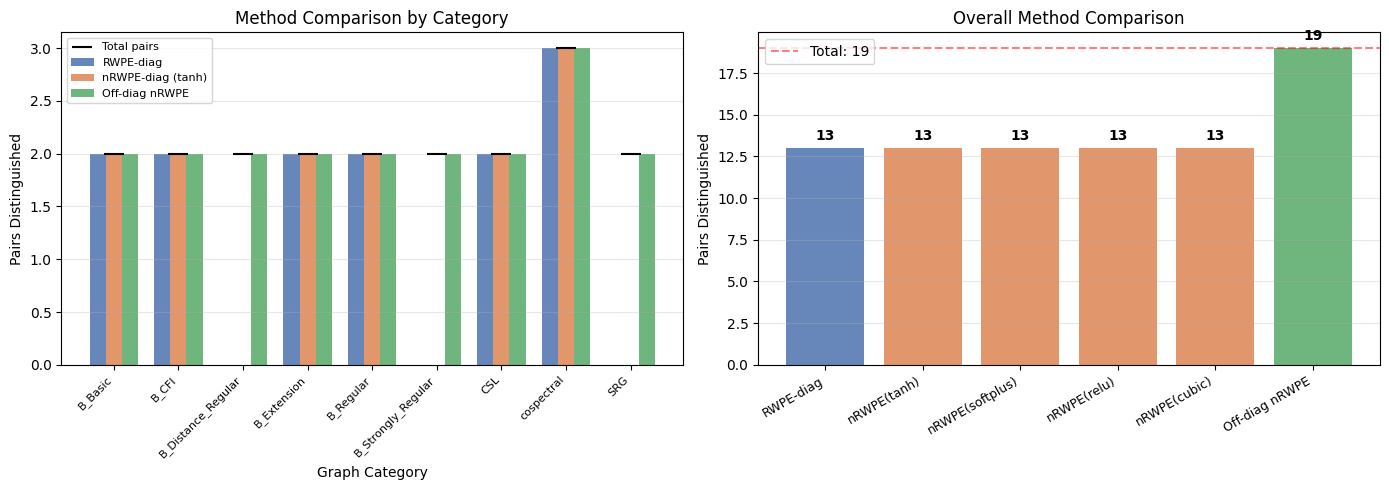


Total computation time: 23.6s


In [13]:
# ── Results Table ──
print("=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)

# Per-category table
print(f"\n{'Category':<25} {'Total':>5} {'RWPE':>6} {'nRWPE':>6} {'Offdiag':>8}")
print("-" * 55)
total_rwpe = 0
total_nrwpe = 0
total_offdiag = 0
total_all = 0
for cat, cb in sorted(category_breakdown.items()):
    print(f"{cat:<25} {cb['total']:>5} {cb['rwpe_dist']:>6} {cb['nrwpe_tanh_dist']:>6} {cb['offdiag_dist']:>8}")
    total_rwpe += cb['rwpe_dist']
    total_nrwpe += cb['nrwpe_tanh_dist']
    total_offdiag += cb['offdiag_dist']
    total_all += cb['total']
print("-" * 55)
print(f"{'TOTAL':<25} {total_all:>5} {total_rwpe:>6} {total_nrwpe:>6} {total_offdiag:>8}")

print(f"\nnRWPE-only pairs (nRWPE distinguishes, RWPE fails): {nrwpe_only_pairs}")
print(f"RWPE-only pairs (RWPE distinguishes, nRWPE fails): {rwpe_only_pairs}")

# SRG results
print(f"\n{'='*60}")
print("SRG Analysis (Rook vs Shrikhande):")
print(f"  RWPE distinguishes: {srg_results['rwpe_distinguishes']}")
for nl_name, r in srg_results['nrwpe_diag'].items():
    print(f"  nRWPE({nl_name}) distinguishes: {r['distinguishes']}")
print(f"  Off-diagonal nRWPE distinguishes: {srg_results['offdiag_nrwpe_tanh_distinguishes']}")

# EDMD results
print(f"\nEDMD: {edmd_distinguishes_count}/{len(edmd_valid)} small pairs distinguished")

# ── Visualization ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Method comparison by category
cats = sorted(category_breakdown.keys())
x = np.arange(len(cats))
width = 0.25

rwpe_vals = [category_breakdown[c]['rwpe_dist'] for c in cats]
nrwpe_vals = [category_breakdown[c]['nrwpe_tanh_dist'] for c in cats]
offdiag_vals = [category_breakdown[c]['offdiag_dist'] for c in cats]
totals = [category_breakdown[c]['total'] for c in cats]

axes[0].bar(x - width, rwpe_vals, width, label='RWPE-diag', color='#4C72B0', alpha=0.85)
axes[0].bar(x, nrwpe_vals, width, label='nRWPE-diag (tanh)', color='#DD8452', alpha=0.85)
axes[0].bar(x + width, offdiag_vals, width, label='Off-diag nRWPE', color='#55A868', alpha=0.85)
# Add total markers
axes[0].scatter(x, totals, color='black', marker='_', s=200, zorder=5, label='Total pairs')

axes[0].set_xlabel('Graph Category')
axes[0].set_ylabel('Pairs Distinguished')
axes[0].set_title('Method Comparison by Category')
axes[0].set_xticks(x)
axes[0].set_xticklabels([c.replace('BREC_', 'B_').replace('strongly_regular', 'SRG') for c in cats],
                         rotation=45, ha='right', fontsize=8)
axes[0].legend(fontsize=8)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Overall method comparison
methods = ['RWPE-diag']
counts = [summary['rwpe_distinguishes_count']]
for nl_name in NONLINEARITY_NAMES:
    methods.append(f'nRWPE({nl_name})')
    counts.append(summary['by_nonlinearity'][nl_name])
methods.append('Off-diag nRWPE')
counts.append(summary['offdiag_nrwpe_distinguishes_count'])

colors = ['#4C72B0'] + ['#DD8452'] * len(NONLINEARITY_NAMES) + ['#55A868']
bars = axes[1].bar(methods, counts, color=colors, alpha=0.85)
axes[1].axhline(y=summary['total_pairs'], color='red', linestyle='--', alpha=0.5, label=f"Total: {summary['total_pairs']}")
axes[1].set_ylabel('Pairs Distinguished')
axes[1].set_title('Overall Method Comparison')
axes[1].set_xticklabels(methods, rotation=30, ha='right', fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, counts):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                 str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nTotal computation time: {phase1_time + sym_time + srg_time + edmd_time:.1f}s")